In [25]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten,InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping


Loading the Dataset

In [2]:
dataset,dataset_info=tfds.load("malaria",with_info=True,split=['train[:80%]','train[80%:90%]',
                                                              'train[90%:]'],shuffle_files=True)
#malaria is a dataset in tensorflow we r directly loading it

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/incomplete.CCRZ2A_1.0.0/malaria-train.tfrecord*...:   0%|         …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [3]:
dataset
#TensorSpec(shape=(None, None, 3)-This shows this is a rbg image
#LABEL:dtype=int->Output is integer

[<_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>]

In [4]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasit

In [5]:
train_ds=dataset[0]
val_ds=dataset[1]
test_ds=dataset[2]

In [6]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

22046
2756
2756


Visualization

In [7]:
def get_label_str(label):
  if label==0:
    return "parasetized"
  else:
    return "uninfected"

1
0
0
1
0
1
0
1
1
1
0
0
0
1
1
0


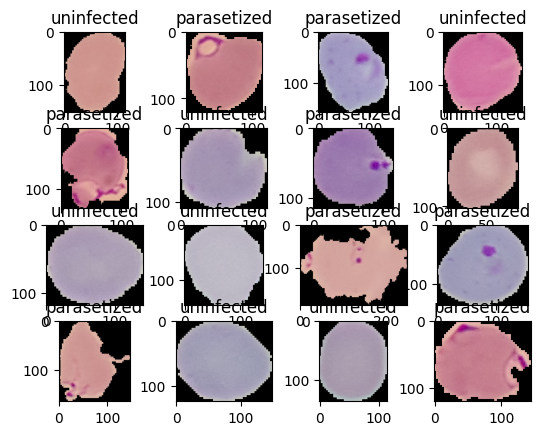

In [8]:
for i,sample in enumerate(train_ds.take(16)):#enumerate() gives you: i → the index (0 to 15) sample → the data point (a dictionary containing image and label)
  ax=plt.subplot(4,4,i+1)#ax = plt.subplot(4, 4, i + 1) plt.subplot(rows, columns, position) places the image in a grid. We're creating a 4 × 4 grid, so it can hold 16 images. i + 1 gives the correct position (1 to 16) in the grid.
  print(sample['label'].numpy())
  plt.imshow(sample['image'])#plt.imshow(sample['image']) Displays the image on the subplot (small section of the big grid). imshow() is used to render the image visually.
  plt.title(get_label_str(sample['label'].numpy()))

In [9]:
#Standardization=x-mean/standard deviation
#normalization=x-x_min/x_max-x_min

In [10]:
IM_SIZE=224
BATCH_SIZE=32
def resize_rescale(inputs):
  return tf.image.resize(inputs['image'],[IM_SIZE,IM_SIZE])/255.0,inputs['label']
#reuturns a resized and normalized image with the label

In [11]:
train_dataset=train_ds.map(resize_rescale).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset=val_ds.map(resize_rescale).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset=test_ds.map(resize_rescale).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
#shuffle-  Shuffle training examples (8 at a time) on each epoch
#batch-  Group data into batches of size BATCH_SIZE
#prefetch(tf.data.AUTOTUNE)-Load next batch while current batch is training (for speed)
#.map() means "do the same thing to every item in the dataset," like resizing all images or changing their values.

**CNN-SUMMARY**
Use CNNs when your data has spatial patterns
→ e.g., images, video frames, audio spectrograms.

Filters/Kernels learn features automatically
  Each filter detects a specific pattern (edge, color, shape).
  Multiple filters → multiple feature maps.

ReLU Activation is used after convolution
  Adds non-linearity, avoids vanishing gradients.

Padding helps retain edge information
  "same" → keeps size same
  "valid" → reduces size

Pooling reduces size and computation
  MaxPooling is most common (takes max value in a region).
  Makes model more robust to small movements in the image.

Flatten before Fully Connected Layers
  Turns 2D feature maps into 1D vectors for classification.
  
Final Layer = Sigmoid or Softmax
  Sigmoid → binary classification
  Softmax → multi-class classification

Training = Forward Pass + Loss + Backpropagation + Optimizer
  Use Cross Entropy Loss for classification
  Use Adam or SGD as optimizers
  
More Layers = Learn deeper patterns
  Shallow layers: basic shapes
  Deep layers: complex objects or concepts

Overfitting is common in CNNs
  Use Dropout, Data Augmentation, or Regularization

CNN MODEL

In [12]:
IM_SIZE=224
model=tf.keras.Sequential([ # Start building a sequential CNN model (layer by layer)
    InputLayer(input_shape=(IM_SIZE,IM_SIZE,3)),# Input layer: Accepts 224x224 pixel images with 3 color channels (RGB)
    Conv2D(filters=6,kernel_size=5,strides=1,padding='valid',activation='relu'),  # Conv Layer 1: 6 filters = the model will learn 6 types of features,  kernel_size=5 = 5x5 patch will scan the image, strides=1 = move 1 pixel at a time, padding='valid' = no padding
    BatchNormalization(),#This normalizes the outputs after each Conv layer, which helps the model converge faster and more stably.
    MaxPool2D(pool_size=2,strides=2),# First pooling layer to reduce image size and keep key features
    Conv2D(filters=16,kernel_size=5,strides=1,padding='valid',activation='relu'), # Second convolutional layer to detect more complex patterns. This will automatically scan from the output produced by the 1st convulational Layer
    BatchNormalization(),
    MaxPool2D(pool_size=2,strides=2), # Second pooling layer to shrink feature maps again
    #Flatten(), # Flatten the 2D output to 1D for feeding into dense layers
    GlobalAveragePooling2D(),## Applies Global Average Pooling to reduce each feature map to a single value (averaging all spatial locations), which helps reduce model size and overfitting by summarizing spatial information.
    #we removed flatten because it was creating overfitting
    Dense(1000,activation="relu"),# First dense layer to learn high-level combinations of features
    Dropout(0.5),
    Dense(100,activation="relu"),# Second dense layer to refine understanding
    Dropout(0.3),
    Dense(1,activation="sigmoid") # Output layer to classify into 2 categories using sigmoid activation
])
model.summary()
#we used relu instead of sigmoid beacuse:	ReLU is now standard in deep learning: faster, avoids vanishing gradients, works better in practice.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 220, 220, 6)    │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 220, 220, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 106, 106, 16)   │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 106, 106, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1000)           │        17,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │       100,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,161 (469.38 KB)

 Trainable params: 120,117 (469.21 KB)

 Non-trainable params: 44 (176.00 B)

Compliation and execution



In [13]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=BinaryCrossentropy(),#we used BinaryCrossentropy becuase our output is gonna be in binary either 0 or 1
    #we would have used rmse or mse if our output was a sequence of numbers to predict
    #we would have used cattegorcalcrossentropy if we had to give our output in various categories
    metrics=[BinaryAccuracy()]
)

In [14]:

checkpoint = ModelCheckpoint(
    'best_model.h5',#File path to save the best model weights
    monitor='val_loss',# Monitor the validation loss during training
    save_best_only=True # Save the model only when val_loss improves (i.e., gets lower)
)
# This checkpoint saves the model to 'best_model.h5' only when the validation loss decreases,
# ensuring that we keep the best-performing model during training and avoid overfitting.

In [21]:
early_stop = EarlyStopping(
    monitor='val_loss',,# Monitors the validation loss
    patience=5,  # Stops training if val_loss doesn't improve for 5 consecutive epochs
    restore_best_weights=True# Restores the model weights from the epoch with the best val_loss
)
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    verbose=1,
    callbacks=[early_stop]
)
# This stops training early if the model stops improving (based on val_loss) for 5 epochs in a row, helping prevent overfitting.

Epoch 1/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 28s 40ms/step - binary_accuracy: 0.9620 - loss: 0.1112 - val_binary_accuracy: 0.9459 - val_loss: 0.1555
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 27s 39ms/step - binary_accuracy: 0.9616 - loss: 0.1116 - val_binary_accuracy: 0.9568 - val_loss: 0.1243
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 28s 41ms/step - binary_accuracy: 0.9635 - loss: 0.1097 - val_binary_accuracy: 0.9554 - val_loss: 0.1231
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 27s 39ms/step - binary_accuracy: 0.9623 - loss: 0.1100 - val_binary_accuracy: 0.9583 - val_loss: 0.1200
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 29s 43ms/step - binary_accuracy: 0.9632 - loss: 0.1076 - val_binary_accuracy: 0.9575 - val_loss: 0.1237
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 39s 39ms/step - binary_accuracy: 0.9614 - loss: 0.1131 - val_binary_accuracy: 0.9583 - val_loss: 0.1186
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 28s 40ms/step - binary_accuracy: 0.9624 - loss: 0.1080 - val_binary_accuracy: 0.9575 - va

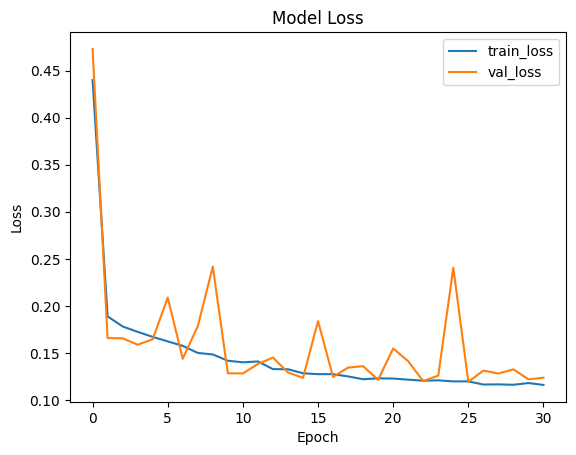

In [16]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel('Epoch')
plt.legend(['train_loss','val_loss'])
plt.show()

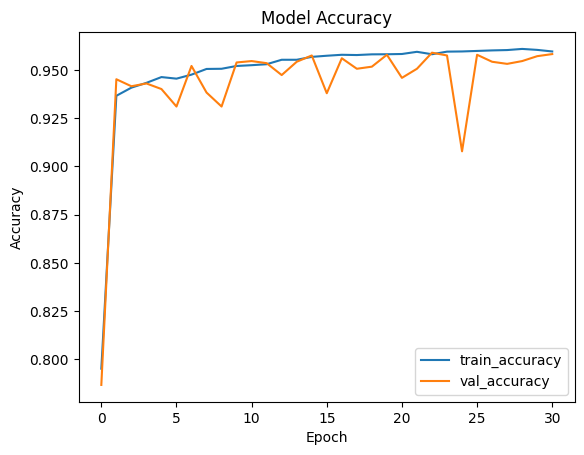

In [17]:
plt.plot(history.history['binary_accuracy'],label='accuracy')
plt.plot(history.history['val_binary_accuracy'],label='val_accuracy')
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel('Epoch')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()

In [22]:
model.evaluate(test_dataset)

87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - binary_accuracy: 0.9660 - loss: 0.1088


[0.11783941835165024, 0.9633526802062988]

In [23]:
def parastite_or_not(x):
  if x<0.5:
    return str("P")
  else:
    return str("U")
# Returns 'P' if predicted probability is below 0.5 (Parasitized), else 'U' (Uninfected)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


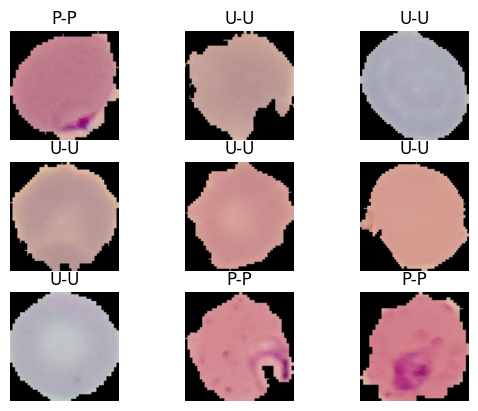

In [24]:
for image,label in test_dataset.take(1):#Take one batch (of 9 images and labels) from the test dataset
  for i in range(9):# Loop through the 9 images in the batch
    ax=plt.subplot(3,3,i+1)# Create a subplot in a 3x3 grid
    plt.imshow(image[i])# Display the i-th image in the batch
    plt.title(parastite_or_not(label.numpy()[i])+"-"+parastite_or_not(model.predict(image)[i][0])) # Set the title to show "TrueLabel - PredictedLabel" (P = Parasitized, U = Uninfected)
    plt.axis("off")# Hide the axis for a cleaner image display